## Multi-fidelity Bayesian Optimization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

import pandas as pd
import torch

from botorch.test_functions.multi_fidelity import AugmentedHartmann
problem = AugmentedHartmann()

def test_function(input_dict):
    x = torch.tensor([input_dict[f"x{i}"] for i in range(1,7)])
    s = torch.tensor(input_dict["s"])
    return {"f":problem(torch.cat(x,s))}


# define vocs
from xopt import VOCS
vocs = VOCS(
    variables={
        "x1": [0, 1],
        "x2": [0, 1],
        "x3": [0, 1],
        "x4": [0, 1],
        "x5": [0, 1],
        "x6": [0, 1],
    },
    objectives={"f": "MINIMIZE"},
)

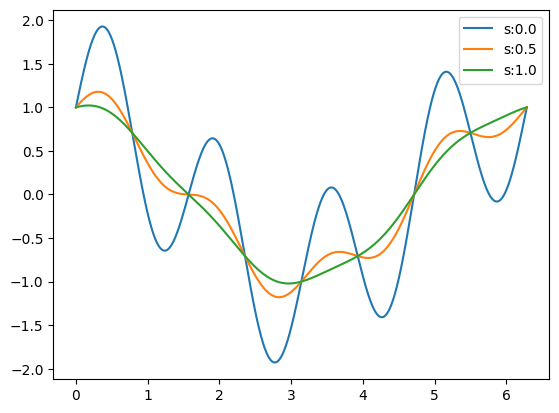

In [2]:
# plot the test function at varying fidelities
test_x = np.linspace(*vocs.bounds, 1000)
fidelities = [0.0,0.5,1.0]

fig,ax = plt.subplots()
for ele in fidelities:
    f = test_function({"x":test_x, "s":ele})["f"]
    ax.plot(test_x, f,label=f"s:{ele}")

ax.legend()

In [3]:
# create xopt object
from xopt.generators import MultiFidelityBayesianGenerator
from xopt import Evaluator, Xopt

# get and modify default generator options
options = MultiFidelityBayesianGenerator.default_options()

# set the base cost of evaluating the function
options.acq.base_cost = 0.1
options.acq.fidelities = [0.0,0.25,0.5,0.75,1.0]

generator = MultiFidelityBayesianGenerator(vocs, options=options)
evaluator = Evaluator(function=test_function)

X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator)

In [4]:
# evaluate initial points at mixed fidelities to seed optimization
X.evaluate_data(pd.DataFrame({"x":[math.pi / 4, math.pi / 2.],"s":[0.0, 0.5]}))

,x,s,f,xopt_runtime,xopt_error
1,0.785398,0.0,7.071068e-01,0.000011,False
2,1.570796,0.5,2.534765e-18,0.000003,False


In [5]:
# get the total cost of previous observations (base_cost + s for each measurement)
X.generator.calculate_total_cost()

0.7

In [6]:
# run optimization until the cost budget is exhausted
budget = 10
while X.generator.calculate_total_cost() < budget:
    print("step")
    X.step()

step
step
step
step
step
step
step
step
step
step
step


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [7]:
X.data

,x,s,f,xopt_runtime,xopt_error
1,0.785398,0.00,7.071068e-01,0.000011,False
2,1.570796,0.50,2.534765e-18,0.000003,False
3,0.000000,0.75,1.000000e+00,0.000012,False
4,6.283185,1.00,1.000000e+00,0.000013,False
5,4.645202,1.00,-8.238579e-02,0.000011,False
6,6.283185,0.50,1.000000e+00,0.000013,False
7,5.754303,0.75,7.630326e-01,0.000013,False
8,0.000000,1.00,1.000000e+00,0.000012,False
9,0.364616,0.75,1.050841e+00,0.000011,False
10,3.120487,0.75,-1.009670e+00,0.000020,False
